<a href="https://colab.research.google.com/github/jmbaek/proteinBERT/blob/main/ProteinBERT_benchmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Check the GPU device**


In [ ]:
!nvidia-smi

Wed Mar 30 12:26:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**2. Load necessry libraries including huggingface transformers**

In [ ]:
!pip -q install transformers

     |████████████████████████████████| 3.8 MB 5.3 MB/s 
     |████████████████████████████████| 67 kB 4.5 MB/s 
     |████████████████████████████████| 596 kB 37.0 MB/s 
     |████████████████████████████████| 895 kB 51.3 MB/s 
     |████████████████████████████████| 6.5 MB 30.5 MB/s 


In [3]:
!wget ftp://ftp.cs.huji.ac.il/users/nadavb/protein_bert/protein_benchmarks/* -P /content/protein_data/

--2022-03-31 01:16:05--  ftp://ftp.cs.huji.ac.il/users/nadavb/protein_bert/protein_benchmarks/*
           => ‘/content/protein_data/.listing’
Resolving ftp.cs.huji.ac.il (ftp.cs.huji.ac.il)... 132.65.116.15
Connecting to ftp.cs.huji.ac.il (ftp.cs.huji.ac.il)|132.65.116.15|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /users/nadavb/protein_bert/protein_benchmarks ... done.
==> PASV ... done.    ==> LIST ... done.

.listing                [ <=>                ]   2.15K  --.-KB/s    in 0.004s  

2022-03-31 01:16:08 (481 KB/s) - ‘/content/protein_data/.listing’ saved [2197]

Removed ‘/content/protein_data/.listing’.
--2022-03-31 01:16:08--  ftp://ftp.cs.huji.ac.il/users/nadavb/protein_bert/protein_benchmarks/PhosphositePTM.test.csv
           => ‘/content/protein_data/PhosphositePTM.test.csv’
==> CWD not required.
==> PASV ... done.    ==> RETR PhosphositePTM.test.csv ... done.
Length: 10368100 (9.9M)

Ph

## Setup

In [14]:
!git clone https://github.com/nadavbra/protein_bert.git
!git clone https://github.com/nadavbra/shared_utils.git
!cp -R protein_bert/proteinbert/ /usr/lib/python3.7/proteinbert/
!cp -R shared_utils/ /usr/lib/python3.7/proteinbert/shared_utils/

fatal: destination path 'protein_bert' already exists and is not an empty directory.
Cloning into 'shared_utils'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 48 (delta 26), reused 37 (delta 15), pack-reused 0
Unpacking objects: 100% (48/48), done.


In [15]:
!cp -R shared_utils/ /usr/lib/python3.7/proteinbert/shared_utils/



In [4]:
BENCHMARKS_DIR = '/content/protein_data/'

## Fine-tune the model for the signal peptide benchmark

In [18]:
!wget ftp://ftp.cs.huji.ac.il/users/nadavb/protein_bert/epoch_92400_sample_23500000.pkl 

--2022-03-31 01:38:25--  ftp://ftp.cs.huji.ac.il/users/nadavb/protein_bert/epoch_92400_sample_23500000.pkl
           => ‘epoch_92400_sample_23500000.pkl’
Resolving ftp.cs.huji.ac.il (ftp.cs.huji.ac.il)... 132.65.116.15
Connecting to ftp.cs.huji.ac.il (ftp.cs.huji.ac.il)|132.65.116.15|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /users/nadavb/protein_bert ... done.
==> SIZE epoch_92400_sample_23500000.pkl ... 191800918
==> PASV ... done.    ==> RETR epoch_92400_sample_23500000.pkl ... done.
Length: 191800918 (183M) (unauthoritative)

epoch_92400_sample_ 100%[===================>] 182.92M  3.65MB/s    in 96s     

2022-03-31 01:40:04 (1.91 MB/s) - ‘epoch_92400_sample_23500000.pkl’ saved [191800918]



In [19]:
!mv epoch_92400_sample_23500000.pkl /root/proteinbert_models/.

mv: cannot move 'epoch_92400_sample_23500000.pkl' to '/root/proteinbert_models/.': No such file or directory


In [17]:
import os

import pandas as pd
from IPython.display import display

from tensorflow import keras

from sklearn.model_selection import train_test_split

from proteinbert import OutputType, OutputSpec, FinetuningModelGenerator, load_pretrained_model, finetune, evaluate_by_len
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs

BENCHMARK_NAME = 'signalP_binary'

# A local (non-global) bianry output
OUTPUT_TYPE = OutputType(False, 'binary')
UNIQUE_LABELS = [0, 1]
OUTPUT_SPEC = OutputSpec(OUTPUT_TYPE, UNIQUE_LABELS)


# Loading the dataset

train_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.train.csv' % BENCHMARK_NAME)
train_set = pd.read_csv(train_set_file_path).dropna().drop_duplicates()
train_set, valid_set = train_test_split(train_set, stratify = train_set['label'], test_size = 0.1, random_state = 0)

test_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.test.csv' % BENCHMARK_NAME)
test_set = pd.read_csv(test_set_file_path).dropna().drop_duplicates()

print(f'{len(train_set)} training set records, {len(valid_set)} validation set records, {len(test_set)} test set records.')


# Loading the pre-trained model and fine-tuning it on the loaded dataset

pretrained_model_generator, input_encoder = load_pretrained_model()

# get_model_with_hidden_layers_as_outputs gives the model output access to the hidden layers (on top of the output)
model_generator = FinetuningModelGenerator(pretrained_model_generator, OUTPUT_SPEC, pretraining_model_manipulation_function = \
        get_model_with_hidden_layers_as_outputs, dropout_rate = 0.5)

training_callbacks = [
    keras.callbacks.ReduceLROnPlateau(patience = 1, factor = 0.25, min_lr = 1e-05, verbose = 1),
    keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True),
]

finetune(model_generator, input_encoder, OUTPUT_SPEC, train_set['seq'], train_set['label'], valid_set['seq'], valid_set['label'], \
        seq_len = 512, batch_size = 32, max_epochs_per_stage = 40, lr = 1e-04, begin_with_frozen_pretrained_layers = True, \
        lr_with_frozen_pretrained_layers = 1e-02, n_final_epochs = 1, final_seq_len = 1024, final_lr = 1e-05, callbacks = training_callbacks)


# Evaluating the performance on the test-set

results, confusion_matrix = evaluate_by_len(model_generator, input_encoder, OUTPUT_SPEC, test_set['seq'], test_set['label'], \
        start_seq_len = 512, start_batch_size = 32)

print('Test-set performance:')
display(results)

print('Confusion matrix:')
display(confusion_matrix)

14945 training set records, 1661 validation set records, 4152 test set records.
 Local model dump file /root/proteinbert_models/default.pkl doesn't exist. Will download ftp://ftp.cs.huji.ac.il/users/nadavb/protein_bert/epoch_92400_sample_23500000.pkl into /root/proteinbert_models. Please approve or reject this (to exit and potentially call the function again with different parameters).
Do you approve downloadig the file into the specified directory? Please specify "Yes" or "No":Yes


FileNotFoundError: ignored

In [ ]:
import os

import pandas as pd
from IPython.display import display

from tensorflow import keras

from sklearn.model_selection import train_test_split

from proteinbert import OutputType, OutputSpec, FinetuningModelGenerator, load_pretrained_model, finetune, evaluate_by_len, log
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs

BENCHMARKS = [
    # name, output_type
    ('signalP_binary', OutputType(False, 'binary')),
    ('fluorescence', OutputType(False, 'numeric')),
    ('remote_homology', OutputType(False, 'categorical')),
    ('stability', OutputType(False, 'numeric')),
    ('scop', OutputType(False, 'categorical')),
    ('secondary_structure', OutputType(True, 'categorical')),
    ('disorder_secondary_structure', OutputType(True, 'binary')),
    ('ProFET_NP_SP_Cleaved', OutputType(False, 'binary')),
    ('PhosphositePTM', OutputType(True, 'binary')),
]

settings = {
    'max_dataset_size': None,
    'max_epochs_per_stage': 40,
    'seq_len': 512,
    'batch_size': 32,
    'final_epoch_seq_len': 1024,
    'initial_lr_with_frozen_pretrained_layers': 1e-02,
    'initial_lr_with_all_layers': 1e-04,
    'final_epoch_lr': 1e-05,
    'dropout_rate': 0.5,
    'training_callbacks': [
        keras.callbacks.ReduceLROnPlateau(patience = 1, factor = 0.25, min_lr = 1e-05, verbose = 1),
        keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True),
    ],
}

####### Uncomment for debug mode
# settings['max_dataset_size'] = 500
# settings['max_epochs_per_stage'] = 1

def run_benchmark(benchmark_name, pretraining_model_generator, input_encoder, pretraining_model_manipulation_function = None):
    
    log('========== %s ==========' % benchmark_name)  
    
    output_type = get_benchmark_output_type(benchmark_name)
    log('Output type: %s' % output_type)
    
    train_set, valid_set, test_set = load_benchmark_dataset(benchmark_name)        
    log(f'{len(train_set)} training set records, {len(valid_set)} validation set records, {len(test_set)} test set records.')
    
    if settings['max_dataset_size'] is not None:
        log('Limiting the training, validation and test sets to %d records each.' % settings['max_dataset_size'])
        train_set = train_set.sample(min(settings['max_dataset_size'], len(train_set)), random_state = 0)
        valid_set = valid_set.sample(min(settings['max_dataset_size'], len(valid_set)), random_state = 0)
        test_set = test_set.sample(min(settings['max_dataset_size'], len(test_set)), random_state = 0)
    
    if output_type.is_seq or output_type.is_categorical:
        train_set['label'] = train_set['label'].astype(str)
        valid_set['label'] = valid_set['label'].astype(str)
        test_set['label'] = test_set['label'].astype(str)
    else:
        train_set['label'] = train_set['label'].astype(float)
        valid_set['label'] = valid_set['label'].astype(float)
        test_set['label'] = test_set['label'].astype(float)
        
    if output_type.is_categorical:
        
        if output_type.is_seq:
            unique_labels = sorted(set.union(*train_set['label'].apply(set)) | set.union(*valid_set['label'].apply(set)) | \
                    set.union(*test_set['label'].apply(set)))
        else:
            unique_labels = sorted(set(train_set['label'].unique()) | set(valid_set['label'].unique()) | set(test_set['label'].unique()))
            
        log('%d unique lebels.' % len(unique_labels))
    elif output_type.is_binary:
        unique_labels = [0, 1]
    else:
        unique_labels = None
        
    output_spec = OutputSpec(output_type, unique_labels)
    model_generator = FinetuningModelGenerator(pretraining_model_generator, output_spec, pretraining_model_manipulation_function = \
            pretraining_model_manipulation_function, dropout_rate = settings['dropout_rate'])
    finetune(model_generator, input_encoder, output_spec, train_set['seq'], train_set['label'], valid_set['seq'], valid_set['label'], \
            seq_len = settings['seq_len'], batch_size = settings['batch_size'], max_epochs_per_stage = settings['max_epochs_per_stage'], \
            lr = settings['initial_lr_with_all_layers'], begin_with_frozen_pretrained_layers = True, lr_with_frozen_pretrained_layers = \
            settings['initial_lr_with_frozen_pretrained_layers'], n_final_epochs = 1, final_seq_len = settings['final_epoch_seq_len'], \
            final_lr = settings['final_epoch_lr'], callbacks = settings['training_callbacks'])
    
    for dataset_name, dataset in [('Training-set', train_set), ('Validation-set', valid_set), ('Test-set', test_set)]:
        
        log('*** %s performance: ***' % dataset_name)
        results, confusion_matrix = evaluate_by_len(model_generator, input_encoder, output_spec, dataset['seq'], dataset['label'], \
                start_seq_len = settings['seq_len'], start_batch_size = settings['batch_size'])
    
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            display(results)
        
        if confusion_matrix is not None:
            with pd.option_context('display.max_rows', 16, 'display.max_columns', 10):
                log('Confusion matrix:')
                display(confusion_matrix)
                
    return model_generator

def load_benchmark_dataset(benchmark_name):
    
    train_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.train.csv' % benchmark_name)
    valid_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.valid.csv' % benchmark_name)
    test_set_file_path = os.path.join(BENCHMARKS_DIR, '%s.test.csv' % benchmark_name)
    
    train_set = pd.read_csv(train_set_file_path).dropna().drop_duplicates()
    test_set = pd.read_csv(test_set_file_path).dropna().drop_duplicates()
          
    if os.path.exists(valid_set_file_path):
        valid_set = pd.read_csv(valid_set_file_path).dropna().drop_duplicates()
    else:
        log(f'Validation set {valid_set_file_path} missing. Splitting training set instead.')
        train_set, valid_set = train_test_split(train_set, stratify = train_set['label'], test_size = 0.1, random_state = 0)
    
    return train_set, valid_set, test_set

def get_benchmark_output_type(benchmark_name):
    for name, output_type in BENCHMARKS:
        if name == benchmark_name:
            return output_type
        
pretrained_model_generator, input_encoder = load_pretrained_model()

for benchmark_name, _ in BENCHMARKS:
    run_benchmark(benchmark_name, pretrained_model_generator, input_encoder, pretraining_model_manipulation_function = \
            get_model_with_hidden_layers_as_outputs)
        
log('Done.')

In [ ]:
import torch
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification
from torch.utils.data import Dataset
import os
import pandas as pd
import requests
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import re

**3. Select the model you want to fine-tune**

In [ ]:
model_name = 'Rostlab/prot_bert_bfd'

**4. Create the Membrane dataset class**

In [ ]:
class DeepLocDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, split="train", tokenizer_name='Rostlab/prot_bert_bfd', max_length=1024):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.datasetFolderPath = 'dataset/'
        self.trainFilePath = os.path.join(self.datasetFolderPath, 'deeploc_per_protein_train.csv')
        self.testFilePath = os.path.join(self.datasetFolderPath, 'deeploc_per_protein_test.csv')

        self.downloadDeeplocDataset()

        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, do_lower_case=False)

        if split=="train":
          self.seqs, self.labels = self.load_dataset(self.trainFilePath)
        else:
          self.seqs, self.labels = self.load_dataset(self.testFilePath)

        self.max_length = max_length

    def downloadDeeplocDataset(self):
        deeplocDatasetTrainUrl = 'https://www.dropbox.com/s/vgdqcl4vzqm9as0/deeploc_per_protein_train.csv?dl=1'
        deeplocDatasetValidUrl = 'https://www.dropbox.com/s/jfzuokrym7nflkp/deeploc_per_protein_test.csv?dl=1'

        if not os.path.exists(self.datasetFolderPath):
            os.makedirs(self.datasetFolderPath)

        def download_file(url, filename):
            response = requests.get(url, stream=True)
            with tqdm.wrapattr(open(filename, "wb"), "write", miniters=1,
                              total=int(response.headers.get('content-length', 0)),
                              desc=filename) as fout:
                for chunk in response.iter_content(chunk_size=4096):
                    fout.write(chunk)

        if not os.path.exists(self.trainFilePath):
            download_file(deeplocDatasetTrainUrl, self.trainFilePath)

        if not os.path.exists(self.testFilePath):
            download_file(deeplocDatasetValidUrl, self.testFilePath)

    def load_dataset(self,path):
        df = pd.read_csv(path,names=['input','loc','membrane'],skiprows=1)
        df = df.loc[df['membrane'].isin(["M","S"])]
        self.labels_dic = {0:'Soluble',
                           1:'Membrane'}

        df['labels'] = np.where(df['membrane']=='M', 1, 0)
        
        seq = list(df['input'])
        label = list(df['labels'])

        assert len(seq) == len(label)
        return seq, label

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        seq = " ".join("".join(self.seqs[idx].split()))
        seq = re.sub(r"[UZOB]", "X", seq)

        seq_ids = self.tokenizer(seq, truncation=True, padding='max_length', max_length=self.max_length)

        sample = {key: torch.tensor(val) for key, val in seq_ids.items()}
        sample['labels'] = torch.tensor(self.labels[idx])

        return sample

**4a. Create the train / val / test datasets**

In [ ]:
train_dataset = DeepLocDataset(split="train", tokenizer_name=model_name, max_length=1024)
val_dataset = DeepLocDataset(split="valid", tokenizer_name=model_name, max_length=1024)
test_dataset = DeepLocDataset(split="test", tokenizer_name=model_name, max_length=1024)

dataset/deeploc_per_protein_train.csv:   0%|          | 0/7417223 [00:00<?, ?it/s]

dataset/deeploc_per_protein_test.csv:   0%|          | 0/2076681 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/361 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


**4b. View datasets**

In [ ]:
df = pd.read_csv('dataset/deeploc_per_protein_train.csv', sep='\,')
df.shape

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


(6622, 3)

In [ ]:
df.input = df.input.str.replace(' ', '')
df['seq_Len'] = df['input'].str.len()
df.head()

,input,loc,membrane,seq_Len
0,MMKTLSSGNCTLNVPAKNSYRMVVLGASRVGKSSIVSRFLNGRFED...,Cell.membrane,M,266
1,MAKRTFSNLETFLIFLLVMMSAITVALLSLLFITSGTIENHKDLGG...,Cell.membrane,M,780
2,MGNCQAGHNLHLCLAHHPPLVCATLILLLLGLSGLGLGSFLLTHRT...,Cell.membrane,M,240
3,MDPSKQGTLNRVENSVYRTAFKLRSVQTLCQLDLMDSFLIQQVLWR...,Cell.membrane,M,653
4,MLLAWVQAFLVSNMLLAEAYGSGGCFWDNGHLYREDQTSPAPGLRC...,Cell.membrane,M,263


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 1500.0)

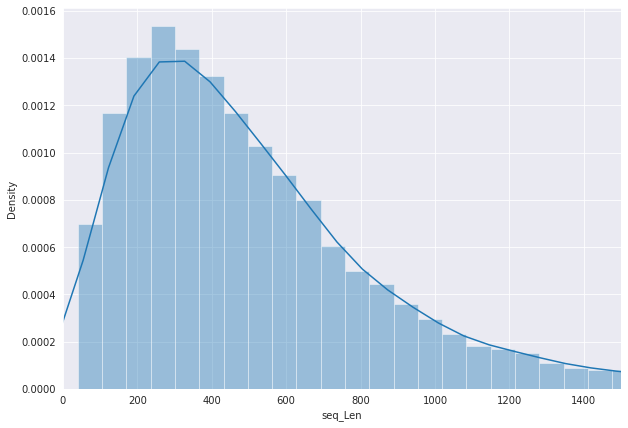

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
seq_len = df['seq_Len']

sns.set_style('darkgrid')
plt.figure(figsize=(10, 7))
sns.distplot(seq_len, bins=200).set_xlim(0,1500)

**5. Define the evaluation metrics**

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

**6. Create the model**

In [ ]:
def model_init():
  return AutoModelForSequenceClassification.from_pretrained(model_name)

**7. Define the training args and start the trainer**

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=1,   # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=100,               # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=200,               # How often to print logs
    do_train=True,                   # Perform training
    do_eval=True,                    # Perform evaluation
    evaluation_strategy="epoch",     # evalute after eachh epoch
    gradient_accumulation_steps=64,  # total number of steps before back propagation
    fp16=True,                       # Use mixed precision
    fp16_opt_level="02",             # mixed precision mode
    run_name="ProBert-BFD-MS",       # experiment name
    seed=3                           # Seed for experiment reproducibility 3x3
)

trainer = Trainer(
    model_init=model_init,                # the instantiated 🤗 Transformers model to be trained
    args=training_args,                   # training arguments, defined above
    train_dataset=train_dataset,          # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics = compute_metrics,    # evaluation metrics
)

trainer.train()

loading configuration file https://huggingface.co/Rostlab/prot_bert_bfd/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/67f460acc7e7e147ff828e909ffe419d00d66ce679c682bc4ab715c107bcbe41.baf557855a8618d0ddfb6c23bfd135bfc38ccf8c3fb099b8df45eb110ccf05e9
Model config BertConfig {
  "_name_or_path": "Rostlab/prot_bert_bfd",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 40000,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 30,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30
}

https://huggingface.co/Rostlab/prot_bert_bfd/resolve/main/pytorch_model.bin not found in ca

Downloading:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

storing https://huggingface.co/Rostlab/prot_bert_bfd/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/0a05878f9e3a0d39834dc6f21b88471696d7453a07bac7246152a6ef307c9af4.c5b9869da882baaf70e8e70cf32d81500803511e3220e24457115a03445fa65f
creating metadata file for /root/.cache/huggingface/transformers/0a05878f9e3a0d39834dc6f21b88471696d7453a07bac7246152a6ef307c9af4.c5b9869da882baaf70e8e70cf32d81500803511e3220e24457115a03445fa65f
loading weights file https://huggingface.co/Rostlab/prot_bert_bfd/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/0a05878f9e3a0d39834dc6f21b88471696d7453a07bac7246152a6ef307c9af4.c5b9869da882baaf70e8e70cf32d81500803511e3220e24457115a03445fa65f
Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.den

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,0.361086,0.885005,0.840764,0.970588,0.741573
1,No log,0.348819,0.872125,0.837427,0.873171,0.804494
2,No log,0.340891,0.877645,0.834371,0.935754,0.752809
3,0.445200,0.344265,0.882245,0.841584,0.936639,0.764045
4,0.445200,0.323444,0.891444,0.853598,0.952909,0.773034
5,0.445200,0.318601,0.889604,0.856459,0.915601,0.804494
6,0.224200,0.331250,0.900644,0.873536,0.911980,0.838202
7,0.224200,0.334955,0.890524,0.861467,0.893720,0.831461
8,0.224200,0.402365,0.894204,0.865811,0.900485,0.833708
9,0.224200,0.407355,0.886845,0.859107,0.876168,0.842697


***** Running Evaluation *****
  Num examples = 1087
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1087
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1087
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1087
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1087
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1087
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1087
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1087
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1087
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1087
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=580, training_loss=0.25753182707161737, metrics={'train_runtime': 23377.7467, 'train_samples_per_second': 1.602, 'train_steps_per_second': 0.025, 'total_flos': 8.711463088316006e+16, 'train_loss': 0.25753182707161737, 'epoch': 9.99})

**8. Save the model**

In [ ]:
trainer.save_model('models/')

Saving model checkpoint to models/
Configuration saved in models/config.json
Model weights saved in models/pytorch_model.bin


In [ ]:

from google.colab import files
!zip -r /content/logs.zip /content/logs/
files.download("/content/logs.zip")
!zip -r /content/models.zip /content/models/
files.download("/content/models.zip")

  adding: content/models/ (stored 0%)
  adding: content/models/pytorch_model.bin (deflated 7%)
  adding: content/models/config.json (deflated 49%)
  adding: content/models/training_args.bin (deflated 48%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**9. Check Tensorboard**

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

**10. Make predictions**

In [ ]:
predictions, label_ids, metrics = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 1087
  Batch size = 32


In [ ]:
for idx in range (0, 20):
  sample_ground_truth = test_dataset.labels_dic[int(test_dataset[idx]['labels'])]
  sample_predictions =  test_dataset.labels_dic[np.argmax(predictions[idx], axis=0)]
  sample_sequence = test_dataset.tokenizer.decode(test_dataset[idx]['input_ids'], skip_special_tokens=True)
  print("Sequence: {} \n\tGround Truth is: {}\n\tprediction is: {}".format(sample_sequence.replace(" ", ""),
                                                                      sample_ground_truth,
                                                                      sample_predictions))

Sequence: MGLPVSWAPPALWVLGCCALLLSLWALCTACRRPEDAVAPRKRARRQRARLQGSATAAEASLLRRTHLCSLSKSDTRLHELHRGPRSSRALRPASMDLLRPHWLEVSRDITGPQAAPSAFPHQELPRALPAAAATAGCAGLEATYSNVGLAALPGVSLAASPVVAEYARVQKRKGTHRSPQEPQQGKTEVTPAAQVDVLYSRVCKPKRRDPGPTTDPLDPKGQGAILALAGDLAYQTLPLRALDVDSGPLENVYESIRELGDPAGRSSTCGAGTPPASSCPSLGRGWRPLPASLP 
	Ground Truth is: Membrane
	prediction is: Membrane
Sequence: MHSRLKFLAYLHFICASSIFWPEFSSAQQQQQTVSLTEKIPLGAIFEQGTDDVQSAFKYAMLNHNLNVSSRRFELQAYVDVINTADAFKLSRLICNQFSRGVYSMLGAVSPDSFDTLHSYSNTFQMPFVTPWFPEKVLAPSSGLLDFAISMRPDYHQAIIDTIQYYGWQSIIYLYDSHDGLLRLQQIYQELKPGNETFRVQMVKRIANVTMAIEFLHTLEDLGRFSKKRIVLDCPAEMAKEIIVQHVRDIKLGRRTYHYLLSGLVMDNHWPSDVVEFGAINITGFRIVDSNRRAVRDFHDSRKRLEPSGQSQSQNAGGPNSLPAISAQAALMYDAVFVLVEAFNRILRKKPDQFRSNHLQRRSHGGSSSSSATGTNESSALLDCNTSKGWVTPWEQGEKISRVLRKVEIDGLSGEIRFDEDGRRINYTLHVVEMSVNSTLQQVAEWRDDAGLLPLHSHNYASSSRSASASTGDYDRNHTYIVSSLLEEPYLSLKQYTYGESLVGNDRFEGYCKDLADMLAAQLGIKYEIRLVQDGNYGAENQYAPGGWDGMVGELIRKEADIAISAMTITAERERVIDFSKPFMTLGISIMIKKPVKQTPGVFSFLNPLSQEIWISVILSYVGVSFVLYFV